In [15]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import os

# Get Data
amd_stock = yf.Ticker('GOOG')
amd_historyAll = amd_stock.history(period="3y").reset_index()

# Delete date since numbers are just fine
amd_historyAll.pop('Date')

# Round Data to be divisible by 50
rounded = 50 * round(len(amd_historyAll)/50)
limitOfDelete = len(amd_historyAll) - rounded
tempList = list(range(0,limitOfDelete))

# Drop Date (useless information that the model doesn't need to know)
amd_historyAll = amd_historyAll.drop(amd_historyAll.index[tempList])
amd_historyAll = amd_historyAll.reset_index()
amd_historyAll.pop('index')
amd_historyAll.pop('Dividends')
amd_historyAll.pop('Stock Splits')

# Creating blank variables
xtrainingAll = pd.DataFrame(columns=['Open', 'High', 'Low','Close', 'Volume'])
xtestingAll = pd.DataFrame(columns=['Open', 'High', 'Low','Close', 'Volume'])

ytrainingAll = pd.DataFrame(columns=['Open', 'High', 'Low','Close', 'Volume'])
ytestingAll = pd.DataFrame(columns=['Open', 'High', 'Low','Close', 'Volume'])

multiplier = 0
# Splitting Data by 50 history points
for x in range(amd_historyAll.shape[0]):
    if x >= multiplier * 250 and x < multiplier * 250 + 50:
      xtestingAll = xtestingAll.append(amd_historyAll.iloc[x])
      ytestingAll = xtestingAll.append(amd_historyAll.iloc[x])
    else:      
      xtrainingAll = xtrainingAll.append(amd_historyAll.loc[x])
      ytrainingAll = ytrainingAll.append(amd_historyAll.loc[x])

    if x == 250 * multiplier + 49:
      multiplier+=1

xtrainingAll1 = xtrainingAll.copy()
xtestingAll1 = xtestingAll.copy()
ytrainingAll1 = ytrainingAll.copy()
ytestingAll1 = ytestingAll.copy()


xHistory = [xtrainingAll,xtestingAll]
yHistory = [ytrainingAll,ytestingAll]

# Deleting the useless columns
for x in xHistory:
   x.pop('Close')

for y in yHistory:
  y.pop('Open')
  y.pop('High')
  y.pop('Low')
  y.pop('Volume')

# Convert DataFrame to numpy array
xtrainingAll2,xtestingAll2 = np.array(xtrainingAll1),np.array(xtestingAll1)
ytrainingAll2,ytestingAll2 = np.array(ytrainingAll1),np.array(ytestingAll1)

# Standarizing Data
std = StandardScaler()
xtrainingAll3 = std.fit_transform(xtrainingAll2)
xtestingAll3 = std.transform(xtestingAll2)

# Normalize, but wont change distribution and weights
scaler = MinMaxScaler(feature_range=(0,1))
xtrainingAll4 = scaler.fit_transform(xtrainingAll3)
xtestingAll4 = scaler.transform(xtestingAll3)

# Splitting Data by 50 history points with x and y division on numpy array
xtrainingAll5,xtestingAll5 = np.array(xtrainingAll4),np.array(xtestingAll4)

xtrainingAllFinal = []
xtestingAllFinal = []

ytrainingAllFinal = []
ytestingAllFinal = []

for x in range(50, xtrainingAll5.shape[0]):
    xtrainingAllFinal.append(xtrainingAll5[x-50:x])
    ytrainingAllFinal.append(ytrainingAll2[x,0])

for x in range(50, xtestingAll5.shape[0]):
    xtestingAllFinal.append(xtestingAll5[x-50:x])
    ytestingAllFinal.append(ytestingAll2[x,0])


xtrainingAllFinal,xtestingAllFinal = np.array(xtrainingAllFinal),np.array(xtestingAllFinal)
ytrainingAllFinal,ytestingAllFinal = np.array(ytrainingAllFinal),np.array(ytestingAllFinal)





In [17]:
if os.path.exists("model1"):
  model = tf.keras.models.load_model('model1')
else:
  # Creating Model 1
  # ? So I want to try starting the first layer with double the amount of neurons as the input size however have 50% dropout
  model = Sequential()
  # Input Layer
  model.add(LSTM(units = 50, activation = 'relu', input_shape=(xtrainingAllFinal.shape[1],xtrainingAllFinal.shape[2]), return_sequences = True))
  # Hidden Layers
  model.add(Dropout(0.2))
  model.add(LSTM(units = 70, return_sequences = True, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 90, return_sequences = True, activation = 'relu'))
  model.add(Dropout(0.35))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.5))
  # Output Layer
  model.add(Dense(units = 1))

  model.summary()
  model.compile(optimizer = 'adam', loss = "mean_squared_error", metrics = 'mean_squared_error')
  history = model.fit(xtrainingAllFinal,ytrainingAllFinal,epochs=10,batch_size = 32, verbose = 1)

  model.save('model1')

# Test Model
yPred = model.predict(xtestingAllFinal)
print('Scaler: ',scaler.scale_)
print('MinMax: ',std.scale_)
print(scaler.scale_[0])

scl = 1/std.scale_[0]  

yPred1,ytestingAllFinal1 = yPred*scl,ytestingAllFinal*scl

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 50)            11200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 70)            33880     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 70)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 90)            57960     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 90)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 120)              

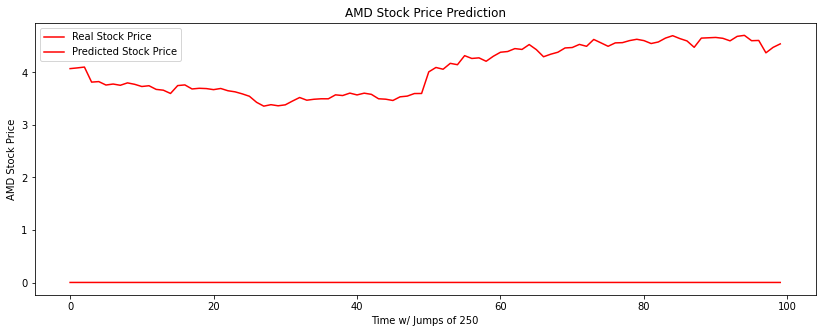

In [19]:
plt.figure(figsize=(14,5))
plt.plot(ytestingAllFinal1, color = 'red', label = "Real Stock Price")
plt.plot(yPred1, color = 'red', label = "Predicted Stock Price")
plt.title('AMD Stock Price Prediction')
plt.xlabel('Time w/ Jumps of 250')
plt.ylabel('AMD Stock Price')
plt.legend()
plt.show()

In [14]:
print(yPred1)

[[2.9060419]
 [2.8936193]
 [2.886926 ]
 [2.8787622]
 [2.8737226]
 [2.8695817]
 [2.8647144]
 [2.8611295]
 [2.8668356]
 [2.87708  ]
 [2.880335 ]
 [2.8917441]
 [2.9048452]
 [2.9159188]
 [2.9278471]
 [2.9429393]
 [2.9579406]
 [2.9678552]
 [2.9827573]
 [2.9962623]
 [3.0083659]
 [3.0216737]
 [3.031723 ]
 [3.029695 ]
 [3.034463 ]
 [3.0143142]
 [3.0054393]
 [3.0032482]
 [3.0047321]
 [3.0074887]
 [3.0135498]
 [3.0230863]
 [3.0350466]
 [3.0485785]
 [3.057541 ]
 [3.0678406]
 [3.070819 ]
 [3.07948  ]
 [3.0850458]
 [3.0888202]
 [3.094869 ]
 [3.0992322]
 [3.0958214]
 [3.0976894]
 [3.101781 ]
 [3.106624 ]
 [3.107716 ]
 [3.108436 ]
 [3.1125758]
 [3.1116111]
 [3.1094973]
 [3.0999563]
 [3.0870855]
 [3.0593233]
 [2.9914834]
 [2.9761252]
 [2.9690533]
 [2.9628172]
 [2.9616315]
 [2.961776 ]
 [2.965076 ]
 [2.9704876]
 [2.9755437]
 [2.97662  ]
 [2.97768  ]
 [2.9746757]
 [2.9783795]
 [2.9846096]
 [2.9897368]
 [2.996131 ]
 [3.0038013]
 [3.0090914]
 [3.0149114]
 [3.017771 ]
 [3.0186505]
 [3.0245156]
 [3.0238562]